In [1]:
"""
!pip install rdt
#this lines only needed to run with google colab
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append("/content/drive/My Drive/CTGAN/CTGAN")#save the git project in CTGAN directory and the git project name is CTGAN (do not forget)
#all of this are saved in google drive of my university account(the directory CTGAN CTGAN is in it)
#this lines only needed to run with google colab
"""
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ctgan import CTGANSynthesizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from utils import *

MODELS_PATH = './models'
DATA_PATH = './data/'
dataset = 'adult'
seed = 1
np.random.seed(seed)

In [2]:
from ctgan import load_demo
data = load_demo()

categorical_features = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
]

data = data.drop(columns=categorical_features)

In [3]:
X, y = data.iloc[:, :-1], data.iloc[:, -1]
le = LabelEncoder()
y = le.fit_transform(y)

In [4]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
categorical_features = []
preprocessor = get_preprocessor(X, categorical_features)
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

#keep train alone and test alone for create excel file in code
#further in the code
X_train_data = X_train.to_numpy()
#excel code use ndarray while here it DATAFRAME
X_test_data = X_test.to_numpy()
#excel code use ndarray while here it DATAFRAME
y_train_data = y_train
y_test_data= y_test
# will used it after/before training
#print(X_test_data)



clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.809


In [5]:
X_train

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
16465,39,188571,7,0,0,40
5625,54,105010,13,0,0,40
30273,32,156464,9,0,1902,50
3136,45,32172,10,0,0,50
4521,60,146674,6,0,0,40
...,...,...,...,...,...,...
32511,25,514716,13,0,0,40
5192,32,207668,13,15024,0,45
12172,27,104457,13,0,0,40
235,59,268700,9,0,0,40


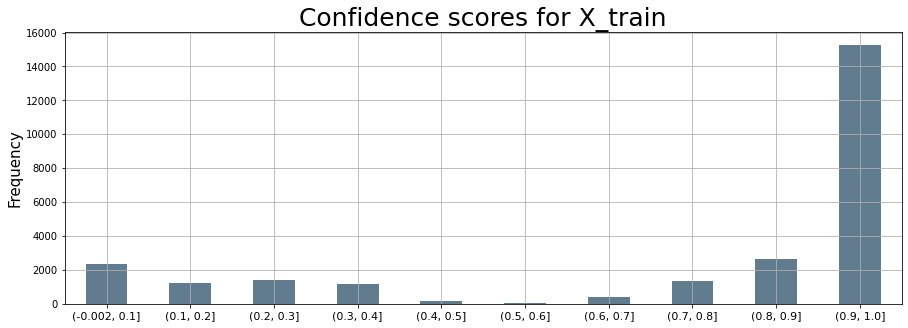

In [6]:
y_prob = clf.predict_proba(X_train)
y_conf_train = y_prob[:, 0]  # confidence scores
plot_confidence_levels(y_conf_train, "Confidence scores for X_train")

In [10]:
# Create bucket (intervals) from generated data
top_c = 10
conf_bucktes = pd.value_counts(y_conf_train, bins=10, sort=False)
idxs, freqs = conf_bucktes.index, conf_bucktes.values
print("conf bucket values:\n")
print(freqs)
print("conf bucket sum of vals:\n")
print(freqs.sum())
# extract top_c intervals by frequency values
intervals_idxs = np.argsort(freqs)[::-1][:top_c]
top_c_intervals = idxs[intervals_idxs]

# create top_c_lst as the middle of the interval
top_c_lst = [(interval.right + interval.left)/2 for interval in top_c_intervals]
top_c_lst = sorted(round(x, 4) for x in top_c_lst)

conf bucket values:

[ 2353  1250  1407  1164   162    62   380  1337  2664 15269]
conf bucket sum of vals:

26048


In [8]:
top_c_lst 

[0.049, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [9]:
"""
# X_all = np.concatenate([X_train, y_train.reshape(-1,1)], axis=1)
# X_train = X_all 
X_train_pd = pd.DataFrame(X_train)
c = top_c_lst[8]
    
# train CTGAN
z_features = get_noise_features(X_train, categorical_features)
z_rows = int(0.25 * X_train.shape[0])
z = gen_random_noise(shape=(z_rows, z_features))

batch_size = 50
epochs = 5
confidence_level = c
gen_lr = 2e-5
loss = 'log'


rf_ctgan = CTGANSynthesizer(batch_size=batch_size,
                            blackbox_model=rf,
                            preprocessing_pipeline=preprocessor,
                            bb_loss=loss,
                            confidence_levels=top_c_lst
                            )

print(f"Training CTGAN for c = {c}...")
allconf_levels_hist = rf_ctgan.fit(train_data=z,
                    epochs=epochs,
                    gen_lr=gen_lr,
                    verbose=False
                    )

# rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")
# plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
# print()


print("\tGenerate samples to same dist...")
# Generate samples to same dist
samples = 100000
gen_data = rf_ctgan.sample(samples,c)
"""

'\n# X_all = np.concatenate([X_train, y_train.reshape(-1,1)], axis=1)\n# X_train = X_all \nX_train_pd = pd.DataFrame(X_train)\nc = top_c_lst[8]\n    \n# train CTGAN\nz_features = get_noise_features(X_train, categorical_features)\nz_rows = int(0.25 * X_train.shape[0])\nz = gen_random_noise(shape=(z_rows, z_features))\n\nbatch_size = 50\nepochs = 5\nconfidence_level = c\ngen_lr = 2e-5\nloss = \'log\'\n\n\nrf_ctgan = CTGANSynthesizer(batch_size=batch_size,\n                            blackbox_model=rf,\n                            preprocessing_pipeline=preprocessor,\n                            bb_loss=loss,\n                            confidence_levels=top_c_lst\n                            )\n\nprint(f"Training CTGAN for c = {c}...")\nallconf_levels_hist = rf_ctgan.fit(train_data=z,\n                    epochs=epochs,\n                    gen_lr=gen_lr,\n                    verbose=False\n                    )\n\n# rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pk

In [10]:
"""
allgeninv= 0
alldataframescoverage =[]
alldataframesprecision =[]
#add here conf loop, send each conf to samples as input each loop
for c in top_c_lst:
    print("\tGenerate samples to same dist...")
    # Generate samples to same dist
    samples = 100000
    gen_data = rf_ctgan.sample(samples,c)
    y_prob = rf.predict_proba(gen_data)
    y_conf_gen = y_prob[:, 0]  # confidence scores


    # ans is the indices of gen_data to make the same dist
    ans = gen_data_to_same_conf_dist_as_train(y_conf_gen, y_conf_train)
    gen_data_same_dist = gen_data.iloc[ans]
    y_conf_gen_same_dist = y_conf_gen[ans]

    # inverse the generated data
    scaler = get_scaler(preprocessor)
    gen_data_inv = scaler.inverse_transform(gen_data_same_dist)
    gen_data_inv = pd.DataFrame(gen_data_inv)
    
    #calc all inv
    
    allgeninv = allgeninv + gen_data_inv.size
    #calc end

    # y_conf_gen_same_dist, gen_data_inv what we want
    # results
    # E. Calculate coverage for each similarity and conf diff thresholds

    #sum all geninvsamples
    #allsamplesInv =allsamplesInv + gen_data_inv.size()

    print(f"\tWorking on results...")
    results,coverage, precision = table(gen_data_inv, X_train_pd, y_conf_gen_same_dist, y_conf_train)
    
    print("datagen inv size:")
    print(gen_data_inv.size)
    print("\n")
    
    #keep all data frames
    alldataframescoverage.append([coverage,gen_data_inv.size])
    alldataframesprecision.append([precision,gen_data_inv.size])
   # allDataFrames.append(results)

    print(f"\tResults for confidence level = {c}")
    display(results)
    
    
    

print("allgen in size")
print(allgeninv)
print("\n")
print("calculate weighted average results\n")
a= alldataframescoverage[0][0] *0
#display(a)
for index in range(len(alldataframescoverage)):
    #func = lambda s1, s2: s1 + s2*alldataframes[index][1]
    a= a+ alldataframescoverage[index][0]*alldataframescoverage[index][1]
a = a/allgeninv
#display weighted averaged coverage
print("display weighted averaged coverage\n")
display(a) 


b= alldataframesprecision[0][0] *0
#display(b)
for index in range(len(alldataframesprecision)):
    #func = lambda s1, s2: s1 + s2*alldataframes[index][1]
    b= b+ alldataframesprecision[index][0]*alldataframesprecision[index][1]
b = b/allgeninv
#display weighted averaged precision
print("display weighted averaged precision\n")
display(b) 

a = a.astype(str)
b = b.astype(str)

result_weighted_Average = a+" | "+b

print("result_weighted_Average:\n")
display(result_weighted_Average)

"""



'\nallgeninv= 0\nalldataframescoverage =[]\nalldataframesprecision =[]\n#add here conf loop, send each conf to samples as input each loop\nfor c in top_c_lst:\n    print("\tGenerate samples to same dist...")\n    # Generate samples to same dist\n    samples = 100000\n    gen_data = rf_ctgan.sample(samples,c)\n    y_prob = rf.predict_proba(gen_data)\n    y_conf_gen = y_prob[:, 0]  # confidence scores\n\n\n    # ans is the indices of gen_data to make the same dist\n    ans = gen_data_to_same_conf_dist_as_train(y_conf_gen, y_conf_train)\n    gen_data_same_dist = gen_data.iloc[ans]\n    y_conf_gen_same_dist = y_conf_gen[ans]\n\n    # inverse the generated data\n    scaler = get_scaler(preprocessor)\n    gen_data_inv = scaler.inverse_transform(gen_data_same_dist)\n    gen_data_inv = pd.DataFrame(gen_data_inv)\n    \n    #calc all inv\n    \n    allgeninv = allgeninv + gen_data_inv.size\n    #calc end\n\n    # y_conf_gen_same_dist, gen_data_inv what we want\n    # results\n    # E. Calculate

In [11]:
#gen_data

In [12]:
"""
y_prob = rf.predict_proba(gen_data)
y_conf_gen = y_prob[:, 0]  # confidence scores

# ans is the indices of gen_data to make the same dist 
ans = gen_data_to_same_conf_dist_as_train(y_conf_gen, y_conf_train)
gen_data_same_dist = gen_data.iloc[ans]
y_conf_gen_same_dist = y_conf_gen[ans]
"""

'\ny_prob = rf.predict_proba(gen_data)\ny_conf_gen = y_prob[:, 0]  # confidence scores\n\n# ans is the indices of gen_data to make the same dist \nans = gen_data_to_same_conf_dist_as_train(y_conf_gen, y_conf_train)\ngen_data_same_dist = gen_data.iloc[ans]\ny_conf_gen_same_dist = y_conf_gen[ans]\n'

In [13]:
#plot_confidence_levels(y_conf_gen_same_dist, "Confidence scores for X_train")

In [14]:
"""
# inverse the generated data
scaler = get_scaler(preprocessor)
gen_data_inv = scaler.inverse_transform(gen_data_same_dist)
gen_data_inv = pd.DataFrame(gen_data_inv)
"""

'\n# inverse the generated data\nscaler = get_scaler(preprocessor)\ngen_data_inv = scaler.inverse_transform(gen_data_same_dist)\ngen_data_inv = pd.DataFrame(gen_data_inv)\n'

In [16]:
"""
# y_conf_gen_same_dist, gen_data_inv what we want
# results
# E. Calculate coverage for each similarity and conf diff thresholds
print(f"\tWorking on results...")
results,coverage, precision = table(gen_data_inv, X_train_pd, y_conf_gen_same_dist, y_conf_train)
print(f"\tResults for confidence level = {c}")
display(results)
"""

'\n# y_conf_gen_same_dist, gen_data_inv what we want\n# results\n# E. Calculate coverage for each similarity and conf diff thresholds\nprint(f"\tWorking on results...")\nresults,coverage, precision = table(gen_data_inv, X_train_pd, y_conf_gen_same_dist, y_conf_train)\nprint(f"\tResults for confidence level = {c}")\ndisplay(results)\n'

In [18]:
import xlsxwriter
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

#create excel file
workbook = xlsxwriter.Workbook('Adult_confidences.xlsx')




#keeps train and test seperatly
#clf.fit(X_train_data, y_train_data)
#y_prob_train_data = rf.predict_proba(X_train_data)
y_conf_train_data = y_conf_train  # confidence scores
#we allready trained with trained data above so only need to chenged
#its variable to fit it to code below
print("y_conf_train_data\n")

#clf.fit(X_test_data, y_test_data)
#no need  to train on test
y_prob_test_data = rf.predict_proba(X_test_data)
y_conf_test_data = y_prob_test_data[:, 0]  # confidence scores
print("y_conf_test_data\n")
#print(y_conf_train)
#keeped



# X_all = np.concatenate([X_train, y_train.reshape(-1,1)], axis=1)
# X_train = X_all
X_train_pd = pd.DataFrame(X_train)



# train CTGAN
z_features = get_noise_features(X_train, categorical_features)
z_rows = int(0.25 * X_train.shape[0])
z = gen_random_noise(shape=(z_rows, z_features))

batch_size = 50
epochs = 50
#confidence_level = c
gen_lr = 2e-5
loss = 'log'

#now ctgan synthesizer gets conf levels as input
rf_ctgan = CTGANSynthesizer(batch_size=batch_size,
                            blackbox_model=rf,
                            preprocessing_pipeline=preprocessor,
                            bb_loss=loss,
                            confidence_levels=top_c_lst
                            )
#print(rf_ctgan.confidence_levels)

print(f"Training CTGAN for c list = {top_c_lst} ...")
#removed conf level from fit input arguements
allconf_levels_hist = rf_ctgan.fit(train_data=z,
                                   epochs=epochs,
                                   gen_lr=gen_lr,
                                   verbose=False
                                  )

#print("\nhistory of all confidence levels:\n")
#print(allconf_levels_hist)
#print("\n\n")
# rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")
# plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
# print()

#allsamplesInv = 0
#allDataFrames = []
#allgeninv= 0
#alldataframescoverage =[]
#alldataframesprecision =[]
freqsCounter = 0
#add here conf loop, send each conf to samples as input each loop

#to delete
#c= top_c_lst[0]
#top_c_lst = [c]
#delete above
for c in top_c_lst:
    print("\tGenerate samples to same dist...")
    # Generate samples to same dist
    samples = 100000
    gen_data = rf_ctgan.sample(samples,c)
    y_prob = rf.predict_proba(gen_data)
    y_conf_gen = y_prob[:, 0]  # confidence scores


    # ans is the indices of gen_data to make the same dist
    ans = gen_data_to_same_conf_dist_as_train(y_conf_gen, y_conf_train)
    gen_data_same_dist = gen_data.iloc[ans]
    y_conf_gen_same_dist = y_conf_gen[ans]

    # inverse the generated data
    scaler = get_scaler(preprocessor)
    gen_data_inv = scaler.inverse_transform(gen_data_same_dist)
    #gen_data_inv = pd.DataFrame(gen_data_inv)

    #find kmean to geninv ndarray
    kmeans = KMeans(n_clusters=1).fit(gen_data_inv)
    gen_data_inv_centroide = kmeans.cluster_centers_

    #create new worksheet, excel for bin Contains Conf c
    name ="bin Contains Conf "+str(c)
    worksheet = workbook.add_worksheet(name)

    #create columns name of excel worksheet
    worksheet.write('A1', 'TR/TS_index')
    worksheet.write('B1', 'train/test')
    worksheet.write('C1', 'cosin_similarity')

    #fill the current worksheet excel
    row =1
    col = 0
    #isTrain= True
    #j=0
    # Iterate over the data and write it out row by row.
    #train_counter = 0
    #print(X_train_data[0])
    #print(X_train_data[0].shape)
    #print(gen_data_inv_centroide)
    #print(gen_data_inv_centroide.shape)
    print("enter train loop excel\n");
    for sample_idx, sample_conf in enumerate (y_conf_train_data):
        #if the conf of data is in the current interval
        #so we want to add it to the excel bin conf
        if(idxs.contains(sample_conf)[freqsCounter]):
            #print("train entered to excel\n")
            #down i reshaped to make the train data[freqcount]
            #to be in 2D as needed(was 1D) and 1 -1 to make it (1,24)
            csm = cosine_similarity(gen_data_inv_centroide, X_train_data[sample_idx].reshape(1,-1)).squeeze()
            #print(csm)
            #print(sample_idx)
            #print(row)
            #print(col)
            worksheet.write(row, col, sample_idx)
            worksheet.write(row, col + 1, 'train')
            worksheet.write(row, col + 2, csm)
           # isTrain = !isTrain
            row += 1
            #j+=1
            #train_counter+=1



    col = 0
    #isTrain= True
    #j=0
    # Iterate over the data and write it out row by row.
    #test_counter = 0
    #print(y_conf_train_data)
    #print(y_conf_test_data)
    print("enter test loop excel\n");
    for sample_idx, sample_conf in enumerate (y_conf_test_data):
        #print("in test loop\n")
        #if the conf of data is in the current interval bin
        #so we want to add it to the excel bin conf
        if(idxs.contains(sample_conf)[freqsCounter]):
            #print("test entered to excel\n")
            csm = cosine_similarity(gen_data_inv_centroide, X_test_data[sample_idx].reshape(1,-1)).squeeze()
            worksheet.write(row, col, sample_idx)
            worksheet.write(row, col + 1, 'test')
            worksheet.write(row, col + 2, csm)
           # isTrain = !isTrain
            row += 1
            #j+=1
            #test_counter+=1



    freqsCounter=freqsCounter+1

workbook.close()

    #calcute and create excel


y_conf_train_data

y_conf_test_data

Training CTGAN for c list = [0.049, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95] ...
	Generate samples to same dist...
enter train loop excel

enter test loop excel

	Generate samples to same dist...
enter train loop excel

enter test loop excel

	Generate samples to same dist...
enter train loop excel

enter test loop excel

	Generate samples to same dist...
enter train loop excel

enter test loop excel

	Generate samples to same dist...
enter train loop excel

enter test loop excel

	Generate samples to same dist...
enter train loop excel

enter test loop excel

	Generate samples to same dist...
enter train loop excel

enter test loop excel

	Generate samples to same dist...
enter train loop excel

enter test loop excel

	Generate samples to same dist...
enter train loop excel

enter test loop excel

	Generate samples to same dist...
enter train loop excel

enter test loop excel

